#Import liberary

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

#Dataset without time

##master_dataset_original

In [ ]:
#loading data and spliting data for the original dataset and dropping the datetime column
df_original = pd.read_csv('master_dataset_orginal.csv')
X = df_original.drop(columns = ['isFraud','TransactionDT'], axis=1)
y = df_original['isFraud']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#Split the dataset again to find the best parameters
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.9, random_state=42, stratify=ytrain)

In [ ]:
xgb_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3]
}
xgb_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42),
    xgb_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1)
xgb_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc')

In [ ]:
#Refit the model with best parameters
best_params = xgb_search.best_params_
best_xgb = xgb.XGBClassifier(**best_params, random_state=42)
best_xgb.fit(Xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
test_score_logloss = -np.mean(cross_val_score(best_xgb, Xtest, ytest, cv=5, scoring='neg_log_loss'))
test_score_accuracy = np.mean(cross_val_score(best_xgb, Xtest, ytest, cv=5, scoring='accuracy'))
test_score_roc = np.mean(cross_val_score(best_xgb, Xtest, ytest, cv=5, scoring='roc_auc'))

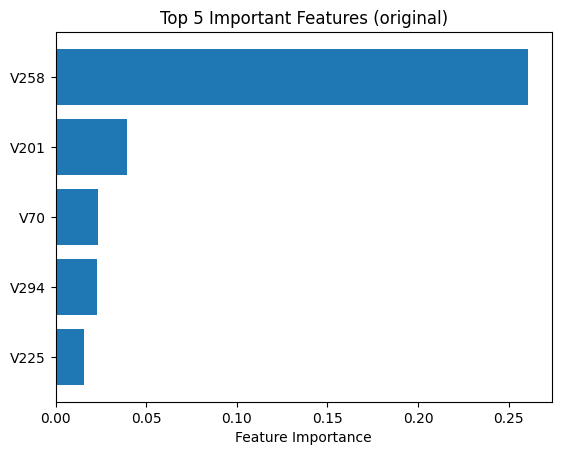

In [ ]:
importances_df = pd.DataFrame({
    'Feature': best_xgb.feature_names_in_,
    'Importance': best_xgb.feature_importances_
})
top5 = importances_df.sort_values(by='Importance', ascending=False).head(5)
plt.barh(top5['Feature'], top5['Importance'])
plt.xlabel("Feature Importance")
plt.title("Top 5 Important Features (original)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# print("Original Test Log Loss:", test_score_logloss)
print("Original Test Accuracy:", test_score_accuracy)
print("Original Test ROC score:", test_score_roc)

Original Test Log Loss: 0.07772444756737021
Original Test Accuracy: 0.9782233066096039
Original Test ROC score: 0.9230026920040612


In [ ]:
xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=100, random_state=42)
xgb.fit(Xtrain, ytrain)

In [ ]:
print(classification_report(ytest, xgb.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.94      0.52      0.67      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.76      0.83    118108
weighted avg       0.98      0.98      0.98    118108



##loading and splitting Data for corr and pca datasets

In [ ]:
# Load dataset
df_corr_reduced = pd.read_csv('master_dataset_corr_features.csv')
df_pca_reduced = pd.read_csv('master_dataset_pca_features.csv')

In [ ]:
# splitting corr data, train 70% valid 15% test 15%
cor_train, cor_val, cor_test = np.split(df_corr_reduced.sample(frac = 1, random_state= 42),
                                                  [int(0.7*len(df_corr_reduced)),
                                                  int(0.85*len(df_corr_reduced))]
)


# splitting pca data, train 70% valid 15% test 15%

pca_train, pca_val, pca_test = np.split(df_pca_reduced.sample(frac = 1, random_state= 42),
                                                  [int(0.7*len(df_pca_reduced)),
                                                  int(0.85*len(df_pca_reduced))]
)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


##master_dataset_corr_features

In [ ]:
# Use 10% of the train dataset to find the best parameter
X_cor_train = cor_train.drop(columns = ['isFraud','TransactionDT'], axis=1)
y_cor_train = cor_train['isFraud']
Xtrain, Xtest, ytrain, ytest = train_test_split(X_cor_train, y_cor_train, test_size=0.9, random_state=42, stratify=y_cor_train)

In [ ]:
xgb_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3]
}
xgb_search_corr = GridSearchCV(
    xgb.XGBClassifier(random_state=42),
    xgb_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1)
xgb_search_corr.fit(Xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc')

In [ ]:
# Find the best model and refit with the whole train dataset
best_params_corr = xgb_search_corr.best_params_
best_xgb_corr = xgb.XGBClassifier(**best_params_corr, random_state=42)
best_xgb_corr.fit(X_cor_train, y_cor_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
X_val = cor_val.drop(columns = ['isFraud','TransactionDT'], axis=1)
y_val = cor_val['isFraud']
corr_val_score_logloss = -np.mean(cross_val_score(best_xgb_corr, X_val, y_val, cv=5, scoring='neg_log_loss'))
corr_val_score_accuracy = np.mean(cross_val_score(best_xgb_corr, X_val, y_val, cv=5, scoring='accuracy'))
corr_val_score_roc = np.mean(cross_val_score(best_xgb_corr, X_val, y_val, cv=5, scoring='roc_auc'))

In [ ]:
X_test = cor_test.drop(columns = ['isFraud','TransactionDT'], axis=1)
y_test = cor_test['isFraud']
corr_test_score_logloss = -np.mean(cross_val_score(best_xgb_corr, X_test, y_test, cv=5, scoring='neg_log_loss'))
corr_test_score_accuracy = np.mean(cross_val_score(best_xgb_corr, X_test, y_test, cv=5, scoring='accuracy'))
corr_test_score_roc = np.mean(cross_val_score(best_xgb_corr, X_test, y_test, cv=5, scoring='roc_auc'))

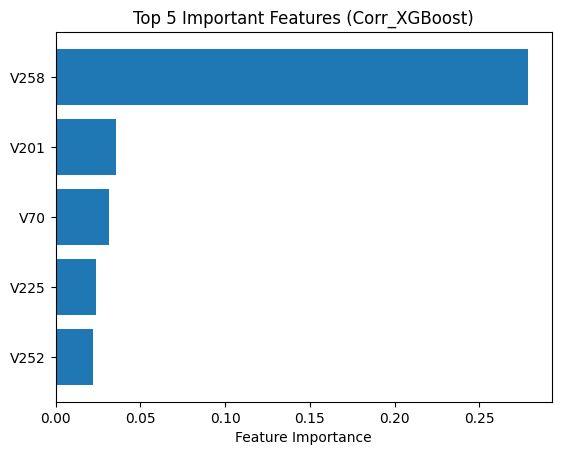

In [ ]:
# Plot importances
corr_importances_df = pd.DataFrame({
    'Feature': best_xgb_corr.feature_names_in_,
    'Importance': best_xgb_corr.feature_importances_
})
top5 = corr_importances_df.sort_values(by='Importance', ascending=False).head(5)
plt.barh(top5['Feature'], top5['Importance'])
plt.xlabel("Feature Importance")
plt.title("Top 5 Important Features (Corr_XGBoost)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
print("Corr Validation Log Loss:", corr_val_score_logloss)
print("Corr Validation Accuracy:", corr_val_score_accuracy)
print("Corr Validation ROC score:", corr_val_score_roc)
print("Corr Test Log Loss:", corr_test_score_logloss)
print("Corr Test Accuracy:", corr_test_score_accuracy)
print("Corr Test ROC score:", corr_test_score_roc)

Corr Validation Log Loss: 0.08476555296704302
Corr Validation Accuracy: 0.9766202568459459
Corr Validation ROC score: 0.9050103720507015
Corr Test Log Loss: 0.08452097544768078
Corr Test Accuracy: 0.9763380375636401
Corr Test ROC score: 0.9101400319180166


##master_dataset_pca_features

In [ ]:
X_pca_train = pca_train.drop(columns = ['isFraud','TransactionDT'], axis=1)
y_pca_train = pca_train['isFraud']
Xtrain, Xtest, ytrain, ytest = train_test_split(X_pca_train, y_pca_train, test_size=0.9, random_state=42, stratify=y_pca_train)

In [ ]:
xgb_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3]
}
xgb_search_pca = GridSearchCV(
    xgb.XGBClassifier(random_state=42),
    xgb_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1)
xgb_search_pca.fit(Xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc')

In [ ]:
best_params_pca = xgb_search_pca.best_params_
best_xgb_pca = xgb.XGBClassifier(**best_params_pca, random_state=42)
best_xgb_pca.fit(X_pca_train, y_pca_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
X_val = pca_val.drop(columns = ['isFraud','TransactionDT'], axis=1)
y_val = pca_val['isFraud']
pca_val_score_logloss = -np.mean(cross_val_score(best_xgb_pca, X_val, y_val, cv=5, scoring='neg_log_loss'))
pca_val_score_accuracy = np.mean(cross_val_score(best_xgb_pca, X_val, y_val, cv=5, scoring='accuracy'))
pca_val_score_roc = np.mean(cross_val_score(best_xgb_pca, X_val, y_val, cv=5, scoring='roc_auc'))

In [ ]:
X_test = pca_test.drop(columns = ['isFraud','TransactionDT'], axis=1)
y_test = pca_test['isFraud']
pca_test_score_logloss = -np.mean(cross_val_score(best_xgb_pca, X_test, y_test, cv=5, scoring='neg_log_loss'))
pca_test_score_accuracy = np.mean(cross_val_score(best_xgb_pca, X_test, y_test, cv=5, scoring='accuracy'))
pca_test_score_roc = np.mean(cross_val_score(best_xgb_pca, X_test, y_test, cv=5, scoring='roc_auc'))

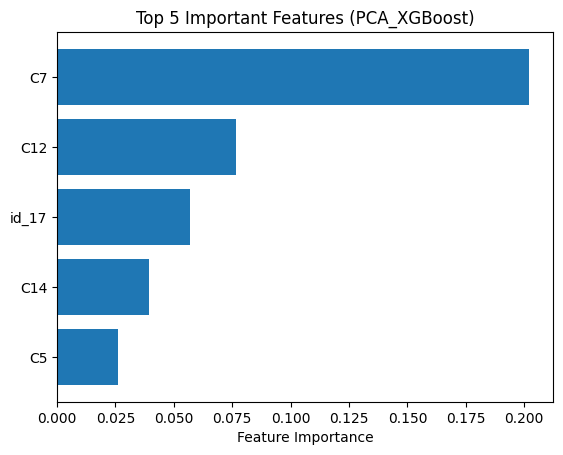

In [ ]:
pca_importances_df = pd.DataFrame({
    'Feature': best_xgb_pca.feature_names_in_,
    'Importance': best_xgb_pca.feature_importances_
})
top5 = pca_importances_df.sort_values(by='Importance', ascending=False).head(5)
plt.barh(top5['Feature'], top5['Importance'])
plt.xlabel("Feature Importance")
plt.title("Top 5 Important Features (PCA_XGBoost)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
print("PCA Validation Log Loss:", pca_val_score_logloss)
print("PCA Validation Accuracy:", pca_val_score_accuracy)
print("PCA Validation ROC score:", pca_val_score_roc)
print("PCA Test Log Loss:", pca_test_score_logloss)
print("PCA Test Accuracy:", pca_test_score_accuracy)
print("PCA Test ROC score:", pca_test_score_roc)

PCA Validation Log Loss: 0.0977423682310976
PCA Validation Accuracy: 0.9768460414474361
PCA Validation ROC score: 0.9029503196468698
PCA Test Log Loss: 0.09683633838964556
PCA Test Accuracy: 0.9771960152261172
PCA Test ROC score: 0.9064583964664227


#Timeseries dataset

In [ ]:
df = pd.read_csv('master_dataset_DTfeatures_LabelEncoded.csv')

In [ ]:
#split data into train(month 12,1,2,3), val(month 4), and test(month 5).
def datasplit(dataframe, oversample = False):

  # setting data thresholds
  train_df = dataframe[(dataframe["month"] < 4) | (dataframe["month"] == 12)]
  val_df = dataframe[dataframe["month"] == 4]
  test_df = dataframe[dataframe["month"] == 5]

  # splittting data
  X_train, Y_train = train_df.drop(columns=["isFraud"]), train_df["isFraud"]
  X_val, y_val = val_df.drop(columns=["isFraud"]), val_df["isFraud"]
  X_test, y_test = test_df.drop(columns=["isFraud"]), test_df["isFraud"]


  if oversample:
        ros = RandomOverSampler()
        X_train, Y_train = ros.fit_resample(X_train, Y_train)


  return X_train, X_val, X_test, Y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, Y_train, y_val, y_test = datasplit(df, oversample=True)
x_train = X_train.copy()
y_train = Y_train.copy()

In [ ]:
#split the trainning set again to find the best parameters
xtrain, xtest, ytrain, ytest = train_test_split(x_train, y_train, test_size=0.9, random_state=42, stratify=y_train)
xgb_params = {
  'n_estimators': [100, 300, 500],
  'max_depth': [3, 6, 10],
  'learning_rate': [0.01, 0.1, 0.3]
  }
xgb_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42),
    xgb_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
    )
xgb_search.fit(xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc')

In [ ]:
#refit the model
best_params = xgb_search.best_params_
best_xgb = xgb.XGBClassifier(**best_params, random_state=42)
best_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
val_score_logloss = -np.mean(cross_val_score(best_xgb, X_val, y_val, cv=5, scoring='neg_log_loss'))
val_score_accuracy = np.mean(cross_val_score(best_xgb, X_val, y_val, cv=5, scoring='accuracy'))
val_score_roc = np.mean(cross_val_score(best_xgb, X_val, y_val, cv=5, scoring='roc_auc'))
test_score_logloss = -np.mean(cross_val_score(best_xgb, X_test, y_test, cv=5, scoring='neg_log_loss'))
test_score_accuracy = np.mean(cross_val_score(best_xgb, X_test, y_test, cv=5, scoring='accuracy'))
test_score_roc = np.mean(cross_val_score(best_xgb, X_test, y_test, cv=5, scoring='roc_auc'))
print("Validation Log Loss:", val_score_logloss)
print("Validation Accuracy:", val_score_accuracy)
print("Validation roc:", val_score_roc)
print("Test Log Loss:", test_score_logloss)
print("Test Accuracy:", test_score_accuracy)
print("Test roc:", test_score_roc)

Validation Log Loss: 0.12199386729162134
Validation Accuracy: 0.9765226226764687
Validation roc: 0.911820935406495
Test Log Loss: 0.2942862913916081
Test Accuracy: 0.8891802490593829
Test roc: 0.8691194510075908


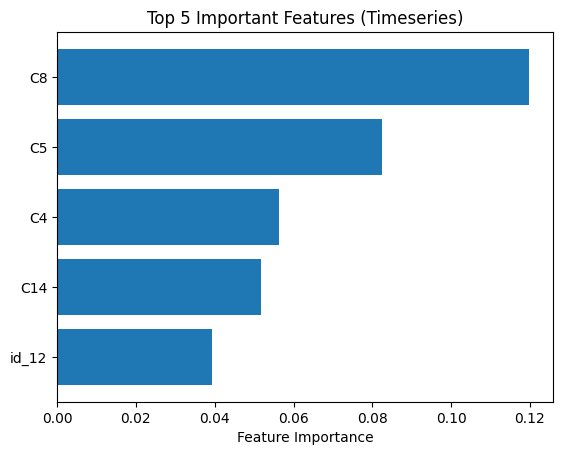

In [ ]:
importances_df = pd.DataFrame({
    'Feature': best_xgb.feature_names_in_,
    'Importance': best_xgb.feature_importances_
})
top5 = importances_df.sort_values(by='Importance', ascending=False).head(5)
plt.barh(top5['Feature'], top5['Importance'])
plt.xlabel("Feature Importance")
plt.title("Top 5 Important Features (Timeseries)")
plt.gca().invert_yaxis()
plt.show()
